# 🔬 Research Framework: A Difference-in-Differences Analysis of BARMM

This notebook conducts a quasi-experimental impact evaluation to assess the causal effect of the establishment of the **Bangsamoro Autonomous Region in Muslim Mindanao (BARMM)** on local economic activity. We employ a **Difference-in-Differences (DiD)** methodology, leveraging a panel dataset of Night-Time Lights (NTL) from 2011 to 2023.

---

### ⚙️ The Difference-in-Differences (DiD) Model

The DiD model isolates the effect of an intervention by comparing the change in an outcome variable over time between a *treatment group* and a *control group*.

> **Key Model Components:**
> *   **Treatment Group**: Municipalities within BARMM (`is_barmm == 1`).
> *   **Control Group**: A comparable set of municipalities outside BARMM (`is_barmm == 0`).
> *   **Intervention (Policy Shock)**: The establishment and inauguration of the BARMM Bangsamoro Transition Authority (BTA), with the "post-treatment" period beginning in **2019**.
> *   **Outcome Variables**: Proxies for economic activity derived from NTL data:
>     *   `_sum`: Total luminosity, a proxy for the magnitude of economic output.
>     *   `_mean`: Average luminosity, a proxy for the intensity of economic activity.
>     *   `_variance`: Spatial inequality of luminosity within a municipality.

The canonical DiD model to be estimated is:

$$ Y_{it} = \beta_0 + \beta_1 \text{BARMM}_i + \beta_2 \text{Post}_t + \delta (\text{BARMM}_i \times \text{Post}_t) + \alpha_i + \lambda_t + \epsilon_{it} $$

Where:
- $ Y_{it} $ is the outcome variable (e.g., `_sum`) for municipality $i$ in year $t$.
- $ \text{BARMM}_i $ is the treatment indicator (1 if the municipality is in BARMM, 0 otherwise).
- $ \text{Post}_t $ is the time indicator (1 for years ≥ 2019, 0 otherwise).
- The interaction term coefficient, $ \delta $, is the **DiD estimator**. It captures the average treatment effect on the treated (ATT).
- $ \alpha_i $ and $ \lambda_t $ represent municipality and year fixed effects, respectively.

---

### 🎯 Research Questions

Our analysis is guided by a set of hierarchical research questions designed to provide comprehensive insights for policy evaluation.

#### **1. Primary Research Question**
*   What has been the causal impact of the establishment of the Bangsamoro Autonomous Region in Muslim Mindanao (BARMM) on local economic activity, as measured by changes in night-time light emissions?

#### **2. Specific Quantitative Questions**
*   📊 **Impact on Economic Output (`_sum`):** Did municipalities within BARMM experience a statistically significant change in total luminosity after 2019 relative to comparable non-BARMM municipalities?
*   💡 **Impact on Economic Intensity (`_mean`):** How did the average light intensity in BARMM municipalities change post-2019 compared to the change in non-BARMM municipalities?
*   🗺️ **Impact on Spatial Inequality (`_variance`):** Has the establishment of BARMM affected the spatial distribution of economic development within its municipalities, as proxied by the variance of night-time lights?

#### **3. Advanced Inquiries: Heterogeneity and Spillovers**
*   **Heterogeneity of Effects:** Is the economic impact of BARMM's establishment uniform across all its constituent areas? Do municipalities with different initial conditions (e.g., income class, pre-existing conflict levels) show differential impacts?
*   **Spillover Effects:** Are there observable economic spillover effects (positive or negative) on geographically adjacent, non-BARMM municipalities?

#### **4. Methodological & Robustness Questions**
*   **Parallel Trends Assumption:** In the pre-treatment period (2011-2018), did the trend of night-time light emissions in BARMM municipalities run parallel to the trend in the selected control group?
*   **Dynamic Effects:** What is the dynamic, year-on-year impact of the intervention? Did the effect manifest immediately, or has it evolved over the subsequent years?
*   **Model Robustness:** How sensitive are the estimated treatment effects to the inclusion of different fixed effects and to the choice of the control group?

---
### **Reference**
*   Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data*. MIT Press.


-------------------------

# 1. Introduction: Evaluating a Landmark Policy

### **Objective**
This analysis evaluates the economic impact of the establishment of the **Bangsamoro Autonomous Region in Muslim Mindanao (BARMM)** in 2019.

### **The Challenge: Measuring Economic Activity**
In many regions, granular, high-frequency economic data is scarce. To overcome this, we use **Night-Time Lights (NTL)** as a proxy for economic activity. NTL data, captured by satellites, is objective, available at a fine geographic scale, and strongly correlated with GDP, infrastructure development, and electricity consumption.

### **Our Approach: A Quasi-Experimental Design**
We will employ a **Difference-in-Differences (DiD)** model. This powerful econometric technique allows us to estimate the causal impact of the BARMM intervention by comparing the change in NTL in BARMM municipalities (the "treatment group") to the change in similar non-BARMM municipalities (the "control group") before and after 2019.
Your Instructions:

### Loading the libraries

In [1]:
# Import necessary libraries
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### Loading the dataset

In [2]:
# In the cell where you define data_directory
data_directory = r'C:\Users\admin\Personal Projects\1 - NTL and BARMM\data\NTL Zonal Statistics'


In [3]:
# --- 2. Initialization: Prepare a list to hold individual dataframes ---
panel_df_list = []

# --- 3. File Iteration and Processing ---
# Get a list of all files in the specified directory.
all_files = os.listdir(data_directory)

# Loop through each file in the directory.
for file_name in all_files:
    # This ensures we only process the relevant Excel files.
    if file_name.startswith('zonal_stat_') and file_name.endswith('.xlsx'):

        # Print the name of the file being processed for progress tracking.
        print(f"Processing file: {file_name}")

        # --- 3a. Extract the Year from the Filename ---
        # Use a regular expression to find the four-digit year in the filename.
        # This is a robust way to handle the naming pattern 'zonal_stat_YYYY_NTL.xlsx'.
        year_match = re.search(r'(\d{4})', file_name)

        if year_match:
            # Extract the year and convert it to an integer.
            year = int(year_match.group(1))

            # --- 3b. Read the Excel File ---
            # Construct the full path to the file.
            file_path = os.path.join(data_directory, file_name)

            # Read the Excel file into a pandas DataFrame.
            temp_df = pd.read_excel(file_path)

            # --- 3c. Add the Year Column ---
            # Create a new 'year' column and assign the extracted year to all rows.
            # This is the key step in creating the time dimension for the panel.
            temp_df['year'] = year

            # --- 3d. Append the DataFrame to the list ---
            # Add the processed dataframe for the current year to our list.
            panel_df_list.append(temp_df)
        else:
            print(f"Warning: Could not extract year from filename: {file_name}")

# --- 4. Consolidation: Combine all DataFrames into a single panel ---
# Check if any files were processed before attempting to concatenate.
if panel_df_list:
    # Concatenate all dataframes in the list into one.
    # `ignore_index=True` resets the index of the resulting dataframe.
    consolidated_panel_df = pd.concat(panel_df_list, ignore_index=True)

    # --- 5. Verification and Output ---
    # Display the first few rows of the final panel dataframe to verify the result.
    print("\n--- Consolidated Panel Data (First 5 Rows) ---")
    print(consolidated_panel_df.head())

    # Display the last few rows to see the most recent year.
    print("\n--- Consolidated Panel Data (Last 5 Rows) ---")
    print(consolidated_panel_df.tail())

    # Display the dimensions (rows, columns) of the final dataframe.
    print(f"\nConsolidated DataFrame dimensions: {consolidated_panel_df.shape}")

    # --- 6. Save the Result ---
    # Save the consolidated panel dataframe to a CSV file for future use.
    # CSV is a standard and efficient format for econometric software.
    output_filename = 'panel_NTL_consolidated.csv'
    consolidated_panel_df.to_csv(output_filename, index=False)
    print(f"\nSuccessfully saved the consolidated panel data to '{output_filename}'")

else:
    print("\nNo matching Excel files were found to process in the specified directory.")

Processing file: zonal_stat_2011_NTL.xlsx
Processing file: zonal_stat_2012_NTL.xlsx
Processing file: zonal_stat_2013_NTL.xlsx
Processing file: zonal_stat_2014_NTL.xlsx
Processing file: zonal_stat_2015_NTL.xlsx
Processing file: zonal_stat_2016_NTL.xlsx
Processing file: zonal_stat_2017_NTL.xlsx
Processing file: zonal_stat_2018_NTL.xlsx
Processing file: zonal_stat_2019_NTL.xlsx
Processing file: zonal_stat_2020_NTL.xlsx
Processing file: zonal_stat_2021_NTL.xlsx
Processing file: zonal_stat_2022_NTL.xlsx
Processing file: zonal_stat_2023_NTL.xlsx

--- Consolidated Panel Data (First 5 Rows) ---
   psgc_code             name   corr_code geo_level city_class inc_class  \
0  907201000  City of Dapitan  97201000.0      City        NaN        CC   
1  907202000  City of Dipolog  97202000.0      City        NaN        CC   
2  907203000        Katipunan  97203000.0       Mun        NaN       NaN   
3  907204000      La Libertad  97204000.0       Mun        NaN       NaN   
4  907205000          Laba

In [4]:
#Rename dataset
df = consolidated_panel_df

In [5]:
#Check if all years are present
df.year.unique()

#Indicator for BARMM Municipalities
df['is_barmm'] = (df['adm1_pcode'] == 'PH19').astype(int)

In [6]:
df.head()

#pop_2015, pop_2020, stat

,psgc_code,name,corr_code,geo_level,city_class,inc_class,urb_rur,pop_2015,pop_2020,status,...,shape_area,shape_sqkm,_count,_sum,_mean,_min,_max,_variance,year,is_barmm
0,907201000,City of Dapitan,97201000.0,City,NaN,CC,3rd,NaN,NaN,NaN,...,0.018092,220.258804,1043.0,121.617922,0.116604,0.0,18.060593,1.241378,2011,0
1,907202000,City of Dipolog,97202000.0,City,NaN,CC,3rd,NaN,NaN,NaN,...,0.009737,118.568691,567.0,158.542016,0.279616,0.0,14.429671,2.004617,2011,0
2,907203000,Katipunan,97203000.0,Mun,NaN,NaN,2nd,NaN,NaN,NaN,...,0.019114,232.816361,1104.0,0.000000,0.000000,0.0,0.000000,0.000000,2011,0
3,907204000,La Libertad,97204000.0,Mun,NaN,NaN,5th,NaN,NaN,NaN,...,0.004504,54.852191,265.0,0.000000,0.000000,0.0,0.000000,0.000000,2011,0
4,907205000,Labason,97205000.0,Mun,NaN,NaN,3rd,NaN,NaN,NaN,...,0.013087,159.548987,757.0,0.000000,0.000000,0.0,0.000000,0.000000,2011,0


In [7]:
# Perform exploratory data analysis
def eda(df):
    data_structure = df.info()
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    duplicates = df.duplicated().sum()
    missing_val = df.isna().sum()

    print(f"Data structure: {data_structure}")
    print("--" * 20)
    print(f"Number of rows: {num_rows}")
    print("--" * 20)
    print(f"Number of cols: {num_cols}")
    print("--" * 20)
    print(f"Number of duplicates: {duplicates}")
    print("--" * 20)
    print(f"Number of missing val: {missing_val}")
    print("--" * 20)

eda(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   psgc_code   6019 non-null   int64  
 1   name        6019 non-null   object 
 2   corr_code   5915 non-null   float64
 3   geo_level   6019 non-null   object 
 4   city_class  455 non-null    object 
 5   inc_class   429 non-null    object 
 6   urb_rur     5915 non-null   object 
 7   pop_2015    0 non-null      float64
 8   pop_2020    78 non-null     object 
 9   status      78 non-null     object 
 10  adm3_pcode  6019 non-null   object 
 11  adm3_en     6019 non-null   object 
 12  adm3_alt    442 non-null    object 
 13  adm2_pcode  6019 non-null   object 
 14  adm1_pcode  6019 non-null   object 
 15  adm0_pcode  6019 non-null   object 
 16  shape_len   6019 non-null   float64
 17  shape_area  6019 non-null   float64
 18  shape_sqkm  6019 non-null   float64
 19  _count      5556 non-null  

In [8]:
df.psgc_code

0        907201000
1        907202000
2        907203000
3        907204000
4        907205000
           ...    
6014    1999904000
6015    1999905000
6016    1999906000
6017    1999907000
6018    1999908000
Name: psgc_code, Length: 6019, dtype: int64

In [9]:
#This means that we truly have a panel dataset of 13 time points and 463 municipalities
df.psgc_code.value_counts()

psgc_code
907201000     13
907202000     13
907203000     13
907204000     13
907205000     13
              ..
1999904000    13
1999905000    13
1999906000    13
1999907000    13
1999908000    13
Name: count, Length: 463, dtype: int64

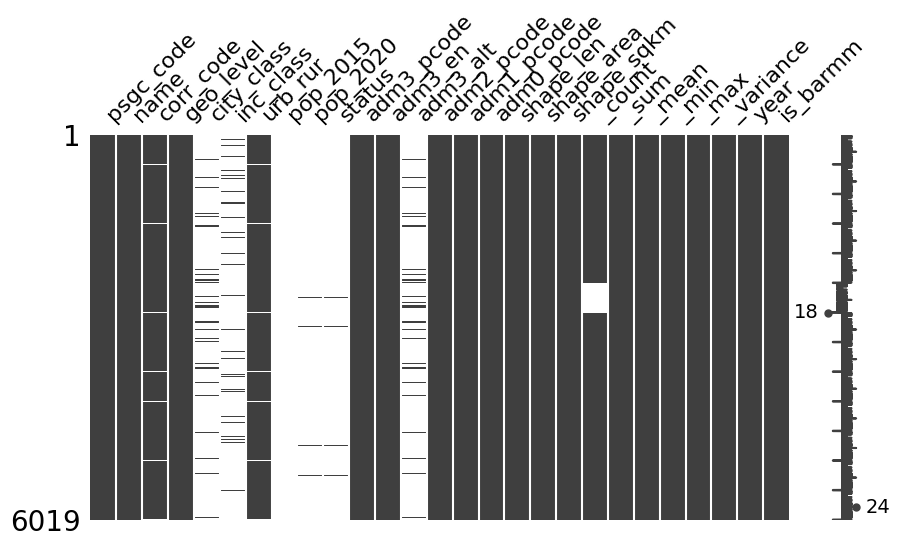

In [10]:
# Visualize missing values
msno.matrix(df, figsize =(10,5))
plt.show()

In [11]:
# Summary stat
statistics = df.describe().T
print("Summary Statistics")
statistics

Summary Statistics


,count,mean,std,min,25%,50%,75%,max
psgc_code,6019.0,1.365033e+09,3.995070e+08,9.072010e+08,1.003518e+09,1.204718e+09,1.900713e+09,1.999908e+09
corr_code,5915.0,1.291038e+08,2.623294e+07,9.720100e+07,1.035150e+08,1.247140e+08,1.538270e+08,1.685070e+08
pop_2015,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shape_len,6019.0,8.456894e-01,5.363434e-01,1.259196e-01,5.138458e-01,7.642103e-01,1.010687e+00,4.719512e+00
shape_area,6019.0,1.769563e-02,1.903816e-02,2.451910e-04,5.523789e-03,1.148672e-02,2.300763e-02,1.917185e-01
shape_sqkm,6019.0,2.159136e+02,2.323523e+02,3.001694e+00,6.739306e+01,1.403086e+02,2.805001e+02,2.341426e+03
_count,5556.0,1.019333e+03,1.097133e+03,1.300000e+01,3.180000e+02,6.710000e+02,1.328000e+03,1.105100e+04
_sum,6019.0,9.318263e+01,6.484314e+02,0.000000e+00,0.000000e+00,2.544431e+00,2.177471e+01,1.634899e+04
_mean,6019.0,7.117691e-02,2.729352e-01,0.000000e+00,0.000000e+00,3.664649e-03,2.919530e-02,4.091412e+00
_min,6019.0,2.380418e-03,6.601720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.381412e+00


In [12]:
# Check all unique values
def unique_values(df):
    for column_name in df.columns:
        print(f"Unique values in: {column_name} column")
        unique_values = df[column_name].unique()
        print(unique_values)
        print('--' * 20)

# Return all unique values for each column
# unique_values(df)

In [13]:
df.columns

Index(['psgc_code', 'name', 'corr_code', 'geo_level', 'city_class',
       'inc_class', 'urb_rur', 'pop_2015', 'pop_2020', 'status', 'adm3_pcode',
       'adm3_en', 'adm3_alt', 'adm2_pcode', 'adm1_pcode', 'adm0_pcode',
       'shape_len', 'shape_area', 'shape_sqkm', '_count', '_sum', '_mean',
       '_min', '_max', '_variance', 'year', 'is_barmm'],
      dtype='object')

In [14]:
df.drop(columns = ['adm0_pcode', 'adm2_pcode', 'adm3_alt', 'pop_2020', 'status', 'pop_2015', 'city_class'], inplace=True, errors='ignore')

eda(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   psgc_code   6019 non-null   int64  
 1   name        6019 non-null   object 
 2   corr_code   5915 non-null   float64
 3   geo_level   6019 non-null   object 
 4   inc_class   429 non-null    object 
 5   urb_rur     5915 non-null   object 
 6   adm3_pcode  6019 non-null   object 
 7   adm3_en     6019 non-null   object 
 8   adm1_pcode  6019 non-null   object 
 9   shape_len   6019 non-null   float64
 10  shape_area  6019 non-null   float64
 11  shape_sqkm  6019 non-null   float64
 12  _count      5556 non-null   float64
 13  _sum        6019 non-null   float64
 14  _mean       6019 non-null   float64
 15  _min        6019 non-null   float64
 16  _max        6019 non-null   float64
 17  _variance   6019 non-null   float64
 18  year        6019 non-null   int64  
 19  is_barmm    6019 non-null  

-----------

# 2. Exploratory Data Analysis: Building the Case for DiD

### **Objective**
Before modeling, we must validate that our treatment and control groups are comparable and that the core assumption of the DiD model—the **parallel trends assumption**—is plausible.

#### **2.1. Pre-Intervention Comparison**
Are BARMM and non-BARMM municipalities different to begin with? We'll check the average NTL levels *before* the 2019 intervention. If they are different, it confirms that a simple before-and-after comparison would be misleading, justifying the need for a DiD approach.

#### **2.2. Visualizing the Parallel Trends Assumption**
This is the most critical plot for our showcase. We will plot the average NTL emissions over time for both the BARMM and non-BARMM groups. For our DiD model to be valid, the trend lines for both groups should be roughly parallel **before** the 2019 intervention.


TypeError: show() got an unexpected keyword argument 'figsize'

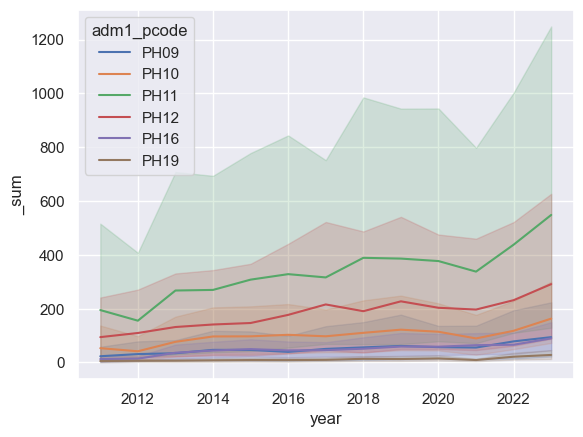

In [22]:
# Plot the outcome for all years and municipalities
sns.lineplot(x="year", y="_sum",
             hue="adm1_pcode",
             data=df)

plt.show(figsize = (4,8))

----------------

# 3. Econometric Modeling: Quantifying the Impact

### **Objective**
We will now estimate the Average Treatment Effect on the Treated (ATT) using a series of regression models. We will build up in complexity to ensure our findings are robust. We use the `statsmodels` library for its R-style regression output, which is standard in econometrics.

#### **3.1. Model 1: The Canonical DiD Model**
Our first model is the standard DiD specification. The coefficient on the interaction term (`is_barmm * post_treatment`) will be our first estimate of the policy's impact.

#### **3.2. Model 2: DiD with Fixed Effects**
To improve robustness, we add **municipality fixed effects**. This controls for all time-invariant unobserved characteristics of each municipality (e.g., geography, institutional history, culture), strengthening our claim to a causal estimate.

#### **3.3. Model 3: The Event Study (Dynamic DiD Model)**
This advanced model unpacks the "post-treatment" period to see the effect year-by-year. Did the impact occur immediately? Does it grow or fade over time? This provides a much richer narrative than a single average effect.
